In [1]:
# Install required packages for precipitation data analysis
%pip install matplotlib seaborn cartopy scikit-learn netcdf4 rasterio rioxarray dask s3fs fsspec zarr

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install numpy xarray

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# NASA POWER vs CHIRPS Version 3 Precipitation Data Analysis

## Comprehensive Comparison for Year 2020 (12-Month Period)

This notebook provides a detailed analysis comparing **NASA POWER precipitation data** (accessed via S3/Zarr) with **CHIRPS Version 3** (Climate Hazards Group InfraRed Precipitation with Station data) for 12 months of 2020 (January-December). We'll examine:

1. **Data Acquisition and Processing** - NASA POWER from S3 and CHIRPS v3 from CHC Portal
2. **Resolution Alignment** - Rescaling CHIRPS v3 (0.05°) to NASA POWER resolution (0.5°)
3. **Statistical Comparisons**
4. **Spatial Analysis**
5. **Temporal Patterns**
6. **Impact Assessment on Applications**
7. **Conclusions and Recommendations**

### Data Sources:
- **NASA POWER:** MERRA-2 precipitation (PRECTOTCORR) from S3 Zarr (0.5° resolution)
- **CHIRPS v3:** High-resolution satellite + station data (0.05° resolution, aggregated to 0.5°)

### Key Questions to Address:
- How do NASA POWER and CHIRPS v3 precipitation estimates compare?
- What are the spatial patterns of agreement/disagreement?
- Which regions show the most variation?
- What implications exist for applications choosing between these datasets?
---

In [3]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import requests
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# S3 and Zarr imports for NASA POWER data
import s3fs
import fsspec
import zarr
import asyncio

# sklearn for statistical metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")

print("Libraries imported successfully!")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Create output directory for figures
output_dir = Path("nasa_chirps_analysis_output")
output_dir.mkdir(exist_ok=True)
print(f"Output directory created: {output_dir}")

# Configuration
ANALYSIS_YEAR = 2020
SPATIAL_EXTENT = {
    'lat_min': -60, 'lat_max': 60,
    'lon_min': -180, 'lon_max': 180
}

# Region for analysis (Sub-Saharan Africa for better comparison)
REGION_BOUNDS = {
    'lat_min': -35, 'lat_max': 20,
    'lon_min': -20, 'lon_max': 50
}

# NASA POWER S3 Configuration (corrected URLs)
NASA_POWER_S3_BASE = "https://nasa-power.s3.us-west-2.amazonaws.com/"
MERRA2_ZARR_HINT = "https://nasa-power.s3.us-west-2.amazonaws.com/merra2/temporal/power_merra2_daily_temporal_lst.zarr"

print(f"Analysis configured for year: {ANALYSIS_YEAR}")

# CHIRPS data directory
data_dir = Path("data/chirps")
data_dir.mkdir(parents=True, exist_ok=True)

Libraries imported successfully!
Analysis Date: 2025-11-12 14:57:46
Output directory created: nasa_chirps_analysis_output
Analysis configured for year: 2020


## 1. Data Acquisition

We'll fetch **NASA POWER precipitation data from S3** and **CHIRPS v3 data from CHC Portal** for 12 months (January-December) to compare the two datasets.

**NASA POWER (MERRA-2):**
- Resolution: 0.5° × 0.625° (~55 km at equator)
- Variable: PRECTOTCORR (bias-corrected total precipitation)
- Source: S3 Zarr archive (Analysis-Ready Data)
- Global coverage
- Assimilated model data with observational corrections

**CHIRPS Version 3 (v3.0):**
- Resolution: 0.05° (~5.5 km at equator)
- Satellite + station data fusion
- Enhanced station network integration
- Better bias correction than v2
- Will be resampled to 0.5° to match NASA POWER

### Data Sources:
- **NASA POWER**: S3 Zarr (MERRA-2 PRECTOTCORR) - https://power-analysis-ready-datastore.s3.amazonaws.com/
- **CHIRPS v3**: https://data.chc.ucsb.edu/products/CHIRPS/v3.0/daily/final/rnl/YYYY/ (daily TIF)

### Processing Strategy:
- **Period**: 12 months (January-December 2020)
- **NASA POWER**: Direct access via S3/Zarr (no download needed)
- **CHIRPS v3**: Download daily TIF files, aggregate to monthly, resample to 0.5°
- **Analysis resolution**: 0.5° (NASA POWER native resolution)

In [4]:
# Import for date calculations
from calendar import monthrange
import rioxarray

# Create data directory
data_dir = Path("nasa_chirps_data")
data_dir.mkdir(exist_ok=True)

# Configuration for analysis - FULL YEAR
START_MONTH = 1
END_MONTH = 12
MONTHS_TO_DOWNLOAD = range(START_MONTH, END_MONTH + 1)

print(f"\nAnalyzing {len(MONTHS_TO_DOWNLOAD)} months of data for {ANALYSIS_YEAR}")
print(f"Period: {ANALYSIS_YEAR}-{START_MONTH:02d} to {ANALYSIS_YEAR}-{END_MONTH:02d}")

# ============================================================================
# PART 1: NASA POWER DATA FROM S3
# ============================================================================

def discover_daily_zarr(bucket_name: str, prefix: str) -> str:
    """Discover a DAILY temporal LST Zarr under a given POWER product prefix."""
    fs = s3fs.S3FileSystem(anon=True)
    full_prefix = f"{bucket_name}/{prefix}"
    keys = [p for p in fs.ls(full_prefix) if p.endswith(".zarr")]
    for k in keys:
        low = k.lower()
        if ("daily" in low) and ("temporal" in low) and ("lst" in low):
            # Extract the path after bucket name
            path = k.split(f"{bucket_name}/", 1)[1]
            return f"{NASA_POWER_S3_BASE}{path}"
    raise RuntimeError(f"No DAILY LST Zarr found under {full_prefix}")

def open_power_zarr(zarr_url: str) -> xr.Dataset:
    """Open NASA POWER Zarr dataset from S3."""
    store = fsspec.get_mapper(zarr_url)
    return xr.open_zarr(store, consolidated=True)

def get_nasa_power_precipitation(year: int, region_bounds: dict) -> xr.DataArray:
    """
    Fetch NASA POWER PRECTOTCORR data from S3 for specified year and region.
    
    Parameters:
    -----------
    year : int
        Year to fetch
    region_bounds : dict
        Dictionary with lat_min, lat_max, lon_min, lon_max
    
    Returns:
    --------
    xr.DataArray : Precipitation data (mm/day)
    """
    print("\n" + "="*70)
    print("FETCHING NASA POWER DATA FROM S3")
    print("="*70)
    
    try:
        # Discover and open MERRA-2 dataset
        print("🔍 Discovering MERRA-2 Zarr dataset...")
        try:
            merra2_url = discover_daily_zarr("nasa-power", "merra2/temporal/")
        except:
            print("   Using hint URL")
            merra2_url = MERRA2_ZARR_HINT
        
        print(f"📂 Opening dataset: {merra2_url}")
        ds_met = open_power_zarr(merra2_url)
        
        print(f"✓ Dataset opened successfully")
        print(f"   Variables available: {list(ds_met.data_vars)[:10]}")
        
        # Check for PRECTOTCORR variable
        if 'PRECTOTCORR' not in ds_met.data_vars:
            raise KeyError("PRECTOTCORR not found in dataset")
        
        # Slice by time and region
        start_date = f"{year}-01-01"
        end_date = f"{year}-12-31"
        
        print(f"\n🔪 Slicing data...")
        print(f"   Time: {start_date} to {end_date}")
        print(f"   Region: {region_bounds}")
        
        precip_data = ds_met['PRECTOTCORR'].sel(
            time=slice(start_date, end_date),
            lat=slice(region_bounds['lat_min'], region_bounds['lat_max']),
            lon=slice(region_bounds['lon_min'], region_bounds['lon_max'])
        )
        
        print(f"\n✓ NASA POWER data acquired successfully!")
        print(f"   Shape: {precip_data.shape}")
        print(f"   Resolution: {float(precip_data.lat[1] - precip_data.lat[0]):.3f}° lat")
        print(f"   Time steps: {len(precip_data.time)}")
        
        return precip_data
        
    except Exception as e:
        print(f"✗ Error fetching NASA POWER data: {e}")
        raise

# ============================================================================
# PART 2: CHIRPS V3 DATA FROM CHC PORTAL
# ============================================================================

def download_chirps_v3_daily(year, months, output_dir):
    """
    Download CHIRPS v3 data (daily TIF files)
    
    Parameters:
    -----------
    year : int
        Year to download
    months : list
        List of months to download
    output_dir : Path
        Directory to save files
    
    Returns:
    --------
    list : Downloaded file paths
    """
    version_dir = output_dir / "chirps_v3"
    version_dir.mkdir(exist_ok=True)
    
    downloaded_files = []
    base_url = f"https://data.chc.ucsb.edu/products/CHIRPS/v3.0/daily/final/rnl/{year}/"
    
    total_files = sum(monthrange(year, m)[1] for m in months)
    print(f"\n   Total files to download: {total_files} daily TIF files")
    
    file_count = 0
    for month in months:
        days_in_month = monthrange(year, month)[1]
        
        for day in range(1, days_in_month + 1):
            filename = f"chirps-v3.0.rnl.{year}.{month:02d}.{day:02d}.tif"
            filepath = version_dir / filename
            
            if filepath.exists():
                file_count += 1
                downloaded_files.append(filepath)
                continue
                
            url = f"{base_url}{filename}"
            
            try:
                response = requests.get(url, timeout=30)
                if response.status_code == 200:
                    with open(filepath, 'wb') as f:
                        f.write(response.content)
                    file_count += 1
                    downloaded_files.append(filepath)
                    if file_count % 10 == 0:
                        print(f"   Downloaded: {file_count}/{total_files} files", end='\r')
            except Exception as e:
                print(f"   Failed to download {filename}: {str(e)}")
                continue
    
    print(f"\n   ✓ CHIRPS v3 download complete: {len(downloaded_files)} files")
    return downloaded_files

def load_chirps_data(file_paths, region_bounds):
    """
    Load CHIRPS v3 daily TIF files into xarray Dataset (ORIGINAL WORKING VERSION)
    
    Parameters:
    -----------
    file_paths : list
        List of file paths to load
    region_bounds : dict
        Dictionary with lat_min, lat_max, lon_min, lon_max
    
    Returns:
    --------
    xr.DataArray : Loaded precipitation data
    """
    print(f"\n   Loading {len(file_paths)} CHIRPS files with rioxarray...")
    print(f"   Using memory-efficient chunked loading...")
    
    v3_datasets = []
    
    for i, tif_file in enumerate(file_paths):
        if i % 30 == 0:
            print(f"   Loading file {i+1}/{len(file_paths)}...", end='\r')
        
        try:
            # Open with chunks to avoid loading full global file into memory at once
            da = rioxarray.open_rasterio(tif_file, masked=True, chunks={'x': 500, 'y': 500})
            
            # Extract date from filename
            filename = tif_file.name
            parts = filename.split('.')
            year_str = parts[3]
            month_str = parts[4]
            day_str = parts[5]
            date = pd.Timestamp(f"{year_str}-{month_str}-{day_str}")
            
            da = da.squeeze().drop_vars('band', errors='ignore')
            
            # Extract regional subset FIRST before any operations to minimize memory
            if 'x' in da.coords and 'y' in da.coords:
                # Select region based on coordinate values
                da_region = da.sel(
                    y=slice(region_bounds['lat_max'], region_bounds['lat_min']),
                    x=slice(region_bounds['lon_min'], region_bounds['lon_max'])
                )
            else:
                da_region = da
            
            # Apply masking only to the regional subset
            da_region = da_region.where(da_region >= 0)
            
            # Display info for first file
            if i == 0:
                da_computed = da_region.compute()
                print(f"\n   ✓ Regional subset extracted successfully")
                print(f"   Regional shape: {da_computed.shape}")
                print(f"   Data range: min={float(da_computed.min()):.2f}, max={float(da_computed.max()):.2f}")
                da_region = da_computed
            
            da_region = da_region.expand_dims(time=[date])
            v3_datasets.append(da_region)
            
        except Exception as e:
            print(f"\n   Warning: Could not load {tif_file.name}: {str(e)}")
            continue
    
    print(f"\n   ✓ Loaded {len(v3_datasets)} files successfully")
    
    # Combine into single dataset
    chirps_da = xr.concat(v3_datasets, dim='time')
    chirps_da.name = 'precipitation'
    
    # Rename coordinates to match standard names
    if 'x' in chirps_da.coords:
        chirps_da = chirps_da.rename({'x': 'lon', 'y': 'lat'})
    
    return chirps_da

# ============================================================================
# MAIN DATA ACQUISITION
# ============================================================================

print("\n" + "="*70)
print("="*70)
print("DATA ACQUISITION: NASA POWER (S3) + CHIRPS V3 (CHC PORTAL)")
print("="*70)

print(f"\nAnalyzing {len(MONTHS_TO_DOWNLOAD)} months of data for {ANALYSIS_YEAR}")
print(f"Period: {ANALYSIS_YEAR}-{START_MONTH:02d} to {ANALYSIS_YEAR}-{END_MONTH:02d}")

print("\n" + "="*70)
print("STEP 1: FETCH NASA POWER DATA")
print("="*70)

nasa_power_precip = get_nasa_power_precipitation(ANALYSIS_YEAR, REGION_BOUNDS)
print("✓ NASA POWER configured (lazy loading)")

print("\n" + "="*70)
print("STEP 2: DOWNLOAD AND LOAD CHIRPS V3 DATA")
print("="*70)

print(f"\n📥 Downloading CHIRPS v3 data...")
chirps_files = download_chirps_v3_daily(ANALYSIS_YEAR, MONTHS_TO_DOWNLOAD, data_dir)

print(f"\n📖 Loading CHIRPS v3 data...")
chirps_v3_precip = load_chirps_data(chirps_files, REGION_BOUNDS)
print("✓ CHIRPS v3 configured (lazy loading)")

print("\n" + "="*70)
print("✓ DATA ACQUISITION COMPLETE")
print("="*70)
print(f"\nNASA POWER shape: {nasa_power_precip.shape}")
print(f"CHIRPS v3 shape: {chirps_v3_precip.shape}")


Analyzing 12 months of data for 2020
Period: 2020-01 to 2020-12

DATA ACQUISITION: NASA POWER (S3) + CHIRPS V3 (CHC PORTAL)

Analyzing 12 months of data for 2020
Period: 2020-01 to 2020-12

STEP 1: FETCH NASA POWER DATA

FETCHING NASA POWER DATA FROM S3
🔍 Discovering MERRA-2 Zarr dataset...
📂 Opening dataset: https://nasa-power.s3.us-west-2.amazonaws.com/merra2/temporal/power_merra2_daily_temporal_lst.zarr
📂 Opening dataset: https://nasa-power.s3.us-west-2.amazonaws.com/merra2/temporal/power_merra2_daily_temporal_lst.zarr
✓ Dataset opened successfully
   Variables available: ['CDD0', 'CDD10', 'CDD18_3', 'DISPH', 'EVLAND', 'EVPTRNS', 'FROST_DAYS', 'FRSEAICE', 'FRSNO', 'GWETPROF']

🔪 Slicing data...
   Time: 2020-01-01 to 2020-12-31
   Region: {'lat_min': -35, 'lat_max': 20, 'lon_min': -20, 'lon_max': 50}

✓ NASA POWER data acquired successfully!
   Shape: (366, 111, 113)
   Resolution: 0.500° lat
   Time steps: 366
✓ NASA POWER configured (lazy loading)

STEP 2: DOWNLOAD AND LOAD CHIRP

## 2. Resolution Alignment and Spatial Analysis Setup

Before comparison, we need to align the resolutions:
- **NASA POWER**: 0.5° native resolution
- **CHIRPS v3**: 0.05° resolution → needs to be aggregated to 0.5°

We'll aggregate CHIRPS v3 to match NASA POWER's coarser resolution using spatial averaging.

In [5]:
# Resolution alignment and spatial analysis setup
print("="*80)
print("RESOLUTION ALIGNMENT AND SPATIAL ANALYSIS")
print("="*80)

# ============================================================================
# STEP 1: ALIGN CHIRPS V3 TO NASA POWER RESOLUTION (0.5°)
# ============================================================================

print("\n1. Aligning CHIRPS v3 to NASA POWER resolution...")

# Get NASA POWER resolution
nasa_lat_res = float(nasa_power_precip.lat[1] - nasa_power_precip.lat[0])
nasa_lon_res = float(nasa_power_precip.lon[1] - nasa_power_precip.lon[0])

print(f"   NASA POWER resolution: {abs(nasa_lat_res):.3f}° lat × {abs(nasa_lon_res):.3f}° lon")
print(f"   CHIRPS v3 native resolution: {abs(float(chirps_v3_precip.lat[1] - chirps_v3_precip.lat[0])):.3f}°")

# Create target grid matching NASA POWER
target_lats = nasa_power_precip.lat.values
target_lons = nasa_power_precip.lon.values

print(f"   Target grid: {len(target_lats)} lat × {len(target_lons)} lon")

# Resample CHIRPS v3 to NASA POWER grid using coarsen (spatial averaging)
# Calculate coarsening factors
chirps_lat_res = abs(float(chirps_v3_precip.lat[1] - chirps_v3_precip.lat[0]))
chirps_lon_res = abs(float(chirps_v3_precip.lon[1] - chirps_v3_precip.lon[0]))

lat_factor = int(round(abs(nasa_lat_res) / chirps_lat_res))
lon_factor = int(round(abs(nasa_lon_res) / chirps_lon_res))

print(f"   Coarsening factors: {lat_factor} lat × {lon_factor} lon")

# Coarsen CHIRPS v3 (spatial averaging)
print("   Resampling CHIRPS v3 (this may take a moment)...")
chirps_v3_coarse = chirps_v3_precip.coarsen(lat=lat_factor, lon=lon_factor, boundary='trim').mean()

# Interpolate to exact NASA POWER coordinates
chirps_v3_aligned = chirps_v3_coarse.interp(
    lat=target_lats,
    lon=target_lons,
    method='linear'
)

print(f"✓ CHIRPS v3 aligned to NASA POWER grid: {chirps_v3_aligned.shape}")

# ============================================================================
# STEP 2: COMPUTE ANNUAL TOTALS
# ============================================================================

print("\n2. Computing annual precipitation totals...")

# Calculate annual totals
print("   Computing NASA POWER annual totals...")
nasa_annual = nasa_power_precip.sum(dim='time')

print("   Computing CHIRPS v3 annual totals...")
chirps_annual = chirps_v3_aligned.sum(dim='time')

print(f"✓ Annual totals computed")
print(f"   NASA POWER shape: {nasa_annual.shape}")
print(f"   CHIRPS v3 shape: {chirps_annual.shape}")

# ============================================================================
# STEP 3: CALCULATE DIFFERENCES
# ============================================================================

print("\n3. Computing differences...")

# Ensure both are on same grid
annual_diff = chirps_annual - nasa_annual
relative_diff = ((chirps_annual - nasa_annual) / nasa_annual) * 100

# Replace inf with nan
relative_diff = relative_diff.where(np.isfinite(relative_diff), np.nan)

print(f"✓ Differences computed")

# ============================================================================
# STEP 4: BASIC STATISTICS
# ============================================================================

print("\n" + "="*80)
print("BASIC STATISTICS")
print("="*80)

# Calculate statistics
def calc_stats(data, name):
    # Compute if dask array
    if hasattr(data, 'compute'):
        data = data.compute()
    return {
        'Dataset': name,
        'Mean (mm/year)': float(data.mean()),
        'Median (mm/year)': float(np.nanmedian(data.values)),
        'Std Dev (mm/year)': float(data.std()),
        'Min (mm/year)': float(data.min()),
        'Max (mm/year)': float(data.max()),
        'Valid Points': int((~np.isnan(data)).sum()),
        'Total Points': int(data.size)
    }

stats_nasa = calc_stats(nasa_annual, 'NASA POWER')
stats_chirps = calc_stats(chirps_annual, 'CHIRPS v3.0')

# Create comparison dataframe
stats_df = pd.DataFrame([stats_nasa, stats_chirps])
print(f"\n=== Dataset Comparison - Annual Precipitation ({ANALYSIS_YEAR}, Sub-Saharan Africa) ===")
print(stats_df.round(2).to_string(index=False))

# Calculate difference statistics
print(f"\n=== Difference Analysis (CHIRPS v3 - NASA POWER) ===")
print(f"Mean difference: {float(annual_diff.mean()):.2f} mm/year")
print(f"Mean absolute difference: {float(np.abs(annual_diff).mean()):.2f} mm/year")
print(f"Mean relative difference: {float(relative_diff.mean()):.2f}%")
print(f"Max positive difference: {float(annual_diff.max()):.2f} mm/year")
print(f"Max negative difference: {float(annual_diff.min()):.2f} mm/year")
print(f"Standard deviation of differences: {float(annual_diff.std()):.2f} mm/year")

# Correlation analysis
nasa_flat = nasa_annual.values.flatten()
chirps_flat = chirps_annual.values.flatten()
mask = ~(np.isnan(nasa_flat) | np.isnan(chirps_flat))
nasa_clean = nasa_flat[mask]
chirps_clean = chirps_flat[mask]

correlation = np.corrcoef(nasa_clean, chirps_clean)[0,1]
print(f"Spatial correlation: {correlation:.4f}")

# Calculate percentage with significant differences
significant_diff = np.abs(relative_diff) > 10
pct_significant = float((np.sum(~np.isnan(significant_diff.values) & significant_diff.values) / np.sum(~np.isnan(significant_diff.values))) * 100)
print(f"Percentage of grid points with >10% difference: {pct_significant:.1f}%")

# Statistical significance
from scipy.stats import pearsonr, spearmanr

pearson_corr, pearson_p = pearsonr(nasa_clean, chirps_clean)
spearman_corr, spearman_p = spearmanr(nasa_clean, chirps_clean)

print(f"\n=== Statistical Significance ===")
print(f"Pearson correlation: {pearson_corr:.4f} (p-value: {pearson_p:.2e})")
print(f"Spearman correlation: {spearman_corr:.4f} (p-value: {spearman_p:.2e})")

# Error metrics
mae = mean_absolute_error(nasa_clean, chirps_clean)
rmse = np.sqrt(mean_squared_error(nasa_clean, chirps_clean))
r2 = r2_score(nasa_clean, chirps_clean)

print(f"\n=== Error Metrics (CHIRPS v3 vs NASA POWER) ===")
print(f"Mean Absolute Error (MAE): {mae:.2f} mm/year")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} mm/year")
print(f"R-squared: {r2:.4f}")

# Store data for visualization
analysis_data = {
    'annual_nasa': nasa_annual,
    'annual_chirps': chirps_annual,
    'annual_diff': annual_diff,
    'relative_diff': relative_diff,
    'region_nasa': nasa_power_precip,
    'region_chirps': chirps_v3_aligned
}

RESOLUTION ALIGNMENT AND SPATIAL ANALYSIS

1. Aligning CHIRPS v3 to NASA POWER resolution...
   NASA POWER resolution: 0.500° lat × 0.625° lon
   CHIRPS v3 native resolution: 0.050°
   Target grid: 111 lat × 113 lon
   Coarsening factors: 10 lat × 12 lon
   Resampling CHIRPS v3 (this may take a moment)...
✓ CHIRPS v3 aligned to NASA POWER grid: (366, 111, 113)

2. Computing annual precipitation totals...
   Computing NASA POWER annual totals...
   Computing CHIRPS v3 annual totals...
✓ Annual totals computed
   NASA POWER shape: (111, 113)
   CHIRPS v3 shape: (111, 113)

3. Computing differences...
✓ Differences computed

BASIC STATISTICS
✓ CHIRPS v3 aligned to NASA POWER grid: (366, 111, 113)

2. Computing annual precipitation totals...
   Computing NASA POWER annual totals...
   Computing CHIRPS v3 annual totals...
✓ Annual totals computed
   NASA POWER shape: (111, 113)
   CHIRPS v3 shape: (111, 113)

3. Computing differences...
✓ Differences computed

BASIC STATISTICS

=== Dataset 

## 3. Spatial Visualization

Visualizing spatial patterns and differences between NASA POWER and CHIRPS v3:

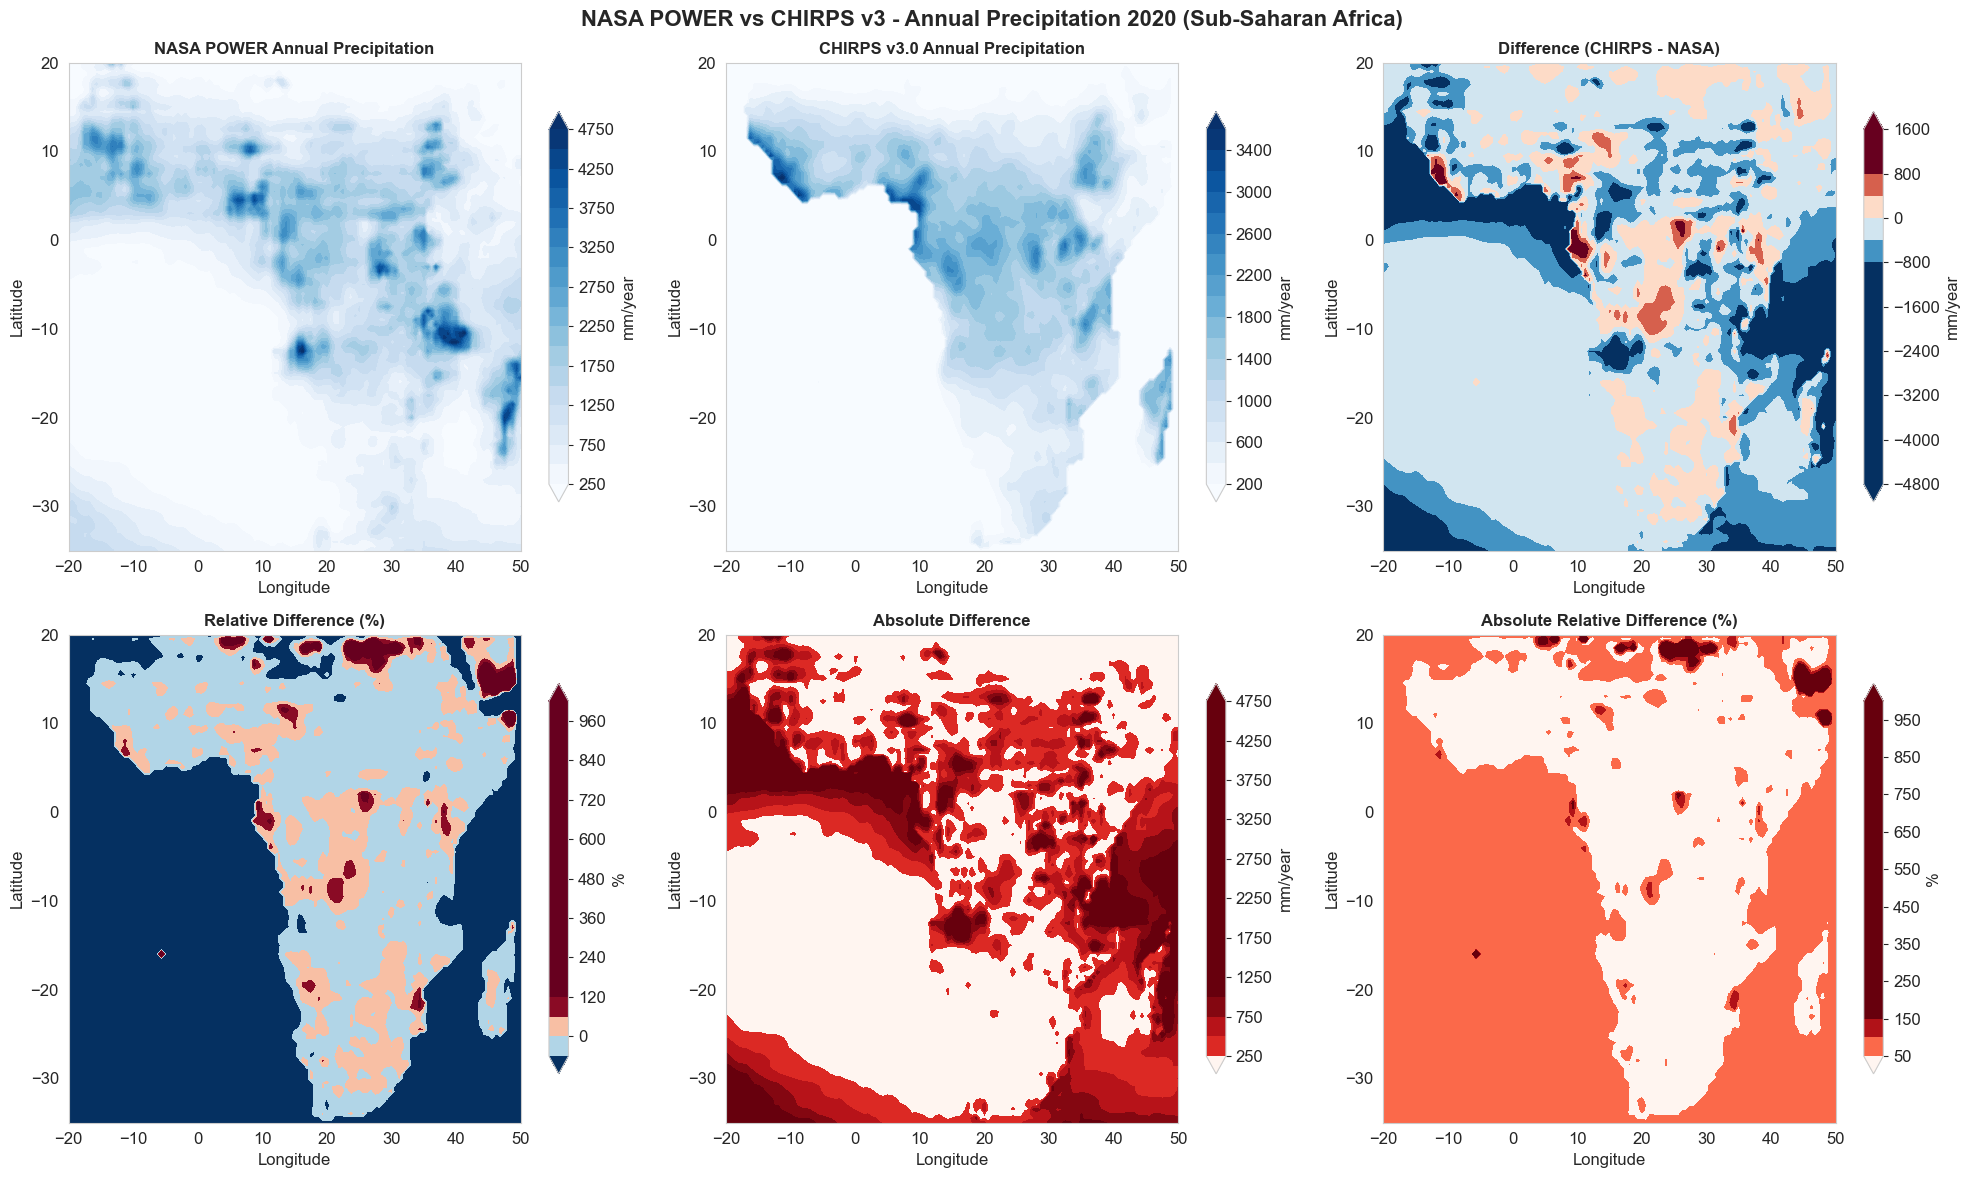

Spatial analysis complete!


In [6]:
# Create comprehensive spatial visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle(f'NASA POWER vs CHIRPS v3 - Annual Precipitation {ANALYSIS_YEAR} (Sub-Saharan Africa)', 
             fontsize=16, fontweight='bold')

# Data for plotting
plot_data = [
    (analysis_data['annual_nasa'], 'NASA POWER Annual Precipitation', 'Blues'),
    (analysis_data['annual_chirps'], 'CHIRPS v3.0 Annual Precipitation', 'Blues'),
    (analysis_data['annual_diff'], 'Difference (CHIRPS - NASA)', 'RdBu_r'),
    (analysis_data['relative_diff'], 'Relative Difference (%)', 'RdBu_r'),
    (np.abs(analysis_data['annual_diff']), 'Absolute Difference', 'Reds'),
    (np.abs(analysis_data['relative_diff']), 'Absolute Relative Difference (%)', 'Reds')
]

# Create subplots
for i, (data, title, cmap) in enumerate(plot_data):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # Handle different value ranges for colormaps
    if 'Relative' in title and 'Absolute' not in title:
        vmin, vmax = -100, 100
    elif 'Difference' in title and 'Relative' not in title:
        vmin, vmax = -1000, 1000
    elif 'Absolute' in title and 'Relative' in title:
        vmax = 150
        vmin = 0
    elif 'Absolute' in title:
        vmax = 1000
        vmin = 0
    else:
        vmin, vmax = None, None
    
    # Use appropriate coordinate names
    if 'nasa' in str(title).lower() or i == 0:
        lon_coord = 'lon'
        lat_coord = 'lat'
    else:
        lon_coord = 'longitude' if 'longitude' in data.dims else 'lon'
        lat_coord = 'latitude' if 'latitude' in data.dims else 'lat'
    
    im = ax.contourf(data[lon_coord], data[lat_coord], data, 
                     levels=20, cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # Add simple grid
    ax.grid(True, alpha=0.3)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    if 'Precipitation' in title:
        cbar.set_label('mm/year')
    elif 'Relative' in title:
        cbar.set_label('%')
    else:
        cbar.set_label('mm/year')

plt.tight_layout()
plt.savefig(output_dir / 'spatial_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Spatial analysis complete!")

## 4. Temporal Analysis and Seasonal Patterns

This section provides comprehensive monthly analysis comparing NASA POWER and CHIRPS v3:
- **Monthly Total Precipitation**: Regional mean precipitation per month
- **Wet Days Analysis**: Days with precipitation >1mm/day
- **Monthly Differences**: Absolute and percentage differences
- **Cumulative Precipitation**: How precipitation accumulates over the year
- **Extreme Events**: Count of extreme precipitation events by month
- **Seasonal Patterns**: DJF, MAM, JJA, SON comparisons

Both datasets are at 0.5° resolution for this analysis.

TEMPORAL ANALYSIS: Monthly Patterns and Characteristics

1. Calculating monthly totals...
2. Calculating wet days per month...
2. Calculating wet days per month...
3. Calculating monthly differences...
3. Calculating monthly differences...
4. Computing cumulative density functions...
4. Computing cumulative density functions...
5. Analyzing extreme events by month...
5. Analyzing extreme events by month...
6. Computing wet days differences...
6. Computing wet days differences...


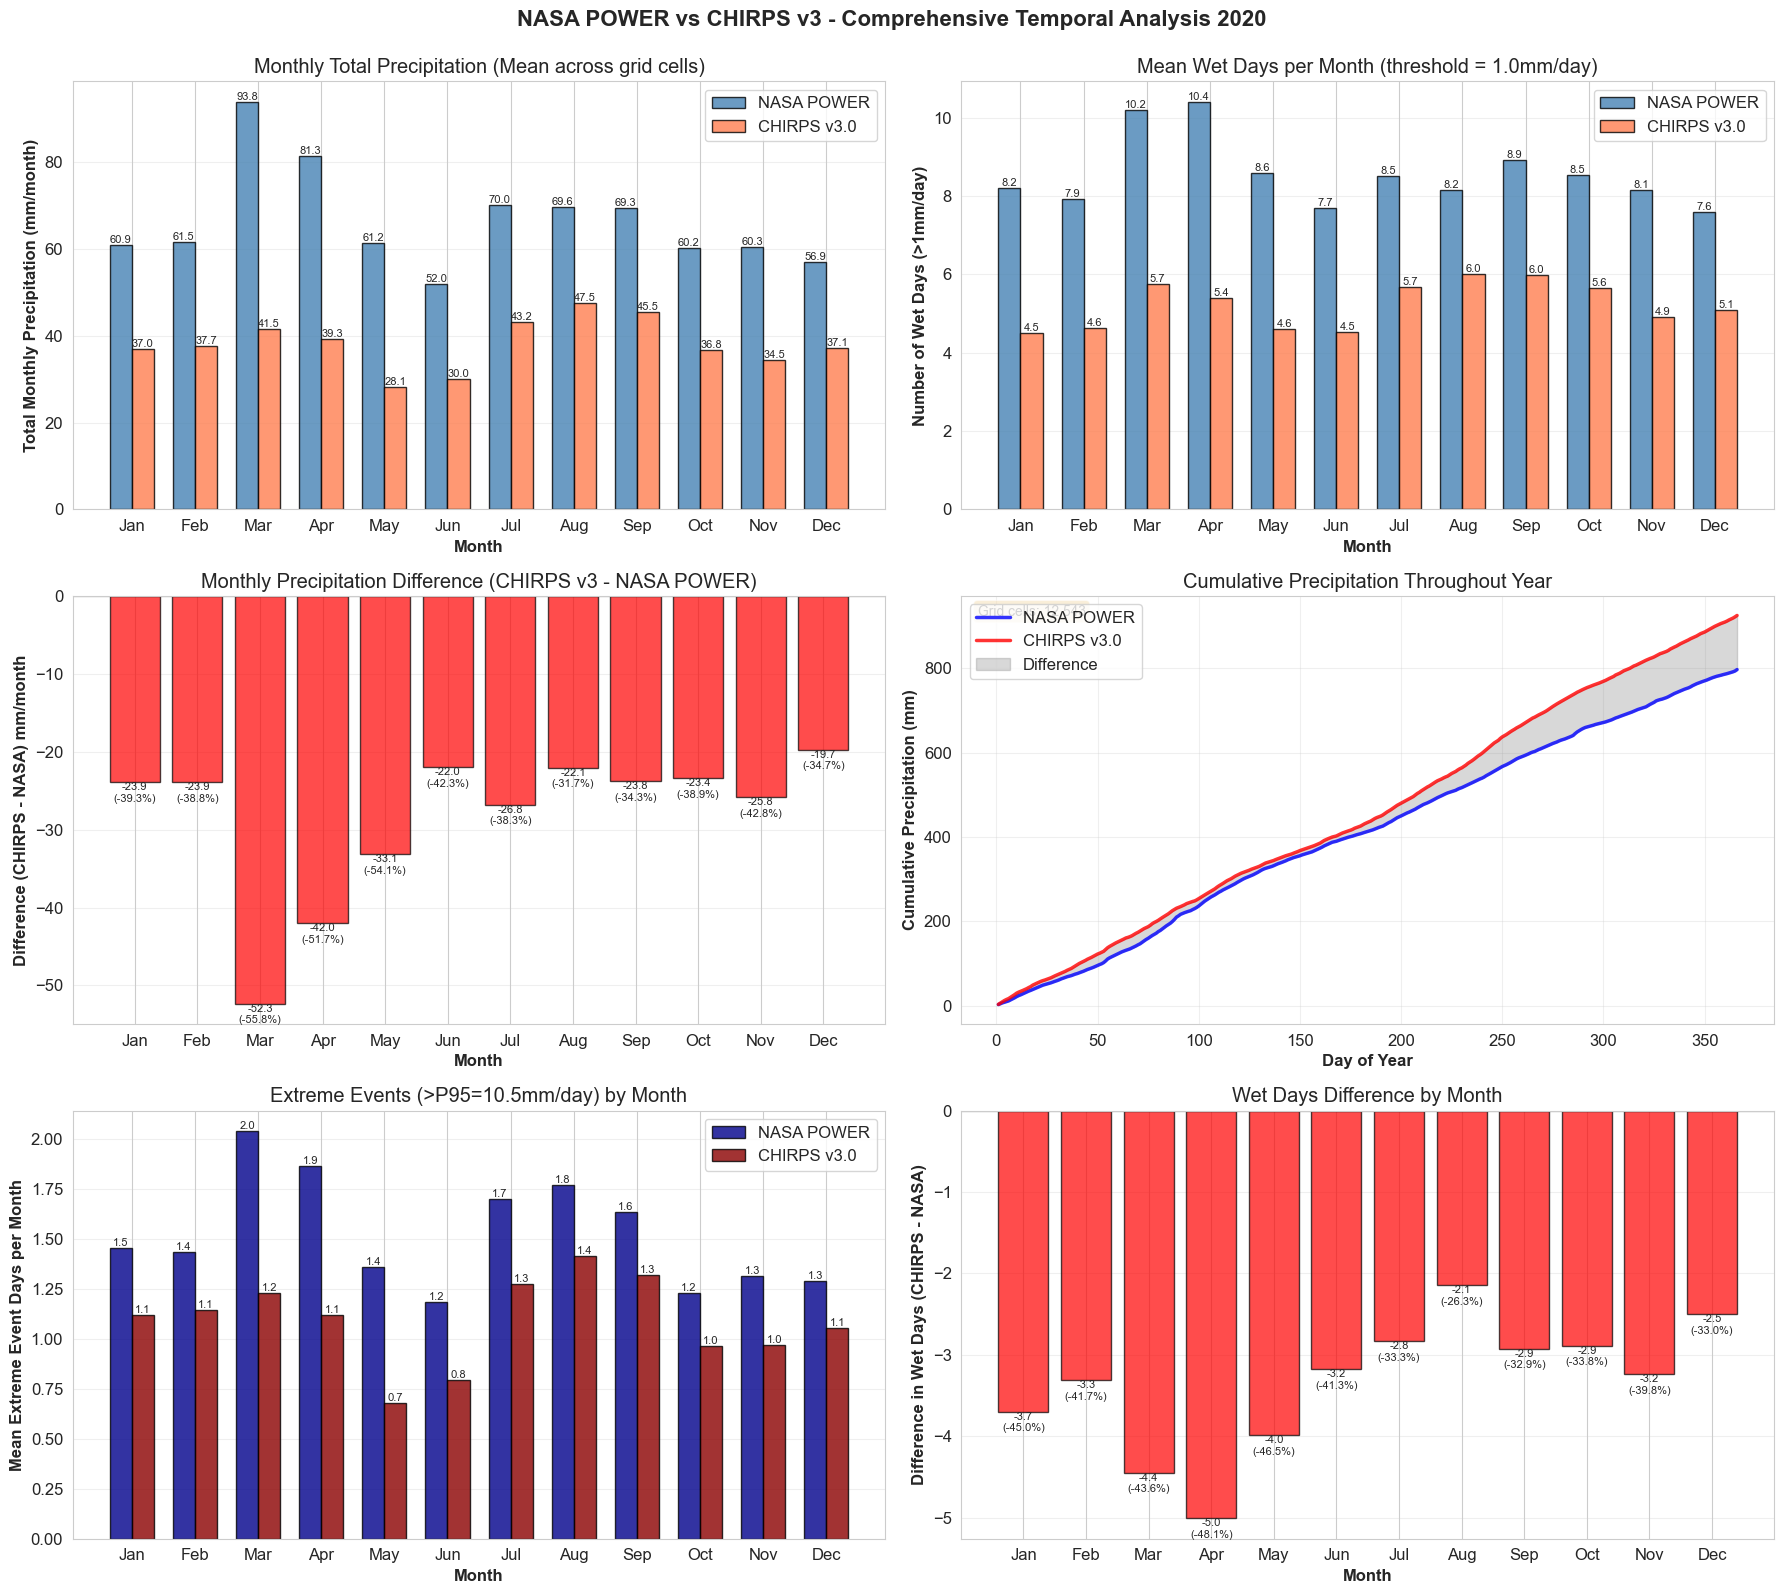


DETAILED TEMPORAL STATISTICS

    Month NASA Total (mm) CHIRPS Total (mm) Diff (mm) Diff (%) NASA Wet Days CHIRPS Wet Days Wet Days Diff
  January            60.9              37.0     -23.9    -39.3           8.2             4.5          -3.7
 February            61.5              37.7     -23.9    -38.8           7.9             4.6          -3.3
    March            93.8              41.5     -52.3    -55.8          10.2             5.7          -4.4
    April            81.3              39.3     -42.0    -51.7          10.4             5.4          -5.0
      May            61.2              28.1     -33.1    -54.1           8.6             4.6          -4.0
     June            52.0              30.0     -22.0    -42.3           7.7             4.5          -3.2
     July            70.0              43.2     -26.8    -38.3           8.5             5.7          -2.8
   August            69.6              47.5     -22.1    -31.7           8.2             6.0          -2.1
Septem

In [7]:
# Temporal analysis - Monthly detailed analysis
print("="*80)
print("TEMPORAL ANALYSIS: Monthly Patterns and Characteristics")
print("="*80)

fig, axes = plt.subplots(3, 2, figsize=(18, 16))
fig.suptitle('NASA POWER vs CHIRPS v3 - Comprehensive Temporal Analysis 2020', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Monthly Total Precipitation (not averaged)
print("\n1. Calculating monthly totals...")
monthly_total_nasa = analysis_data['region_nasa'].groupby('time.month').sum().mean(dim=['lat', 'lon'])
monthly_total_chirps = analysis_data['region_chirps'].groupby('time.month').sum().mean(dim=['lat', 'lon'])

ax1 = axes[0, 0]
months_available = monthly_total_nasa.month.values
x = np.arange(len(months_available))
width = 0.35
bars1 = ax1.bar(x - width/2, monthly_total_nasa.values, width, label='NASA POWER', 
                color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x + width/2, monthly_total_chirps.values, width, label='CHIRPS v3.0', 
                color='coral', alpha=0.8, edgecolor='black')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

ax1.set_xlabel('Month', fontweight='bold')
ax1.set_ylabel('Total Monthly Precipitation (mm/month)', fontweight='bold')
ax1.set_title('Monthly Total Precipitation (Mean across grid cells)')
ax1.set_xticks(x)
ax1.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][:len(months_available)])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. Number of Wet Days per Month (precipitation > 1mm/day threshold)
print("2. Calculating wet days per month...")
wet_threshold = 1.0  # mm/day
wet_days_nasa = (analysis_data['region_nasa'] > wet_threshold).groupby('time.month').sum().mean(dim=['lat', 'lon'])
wet_days_chirps = (analysis_data['region_chirps'] > wet_threshold).groupby('time.month').sum().mean(dim=['lat', 'lon'])

ax2 = axes[0, 1]
bars1 = ax2.bar(x - width/2, wet_days_nasa.values, width, label='NASA POWER', 
                color='steelblue', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x + width/2, wet_days_chirps.values, width, label='CHIRPS v3.0', 
                color='coral', alpha=0.8, edgecolor='black')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)

ax2.set_xlabel('Month', fontweight='bold')
ax2.set_ylabel('Number of Wet Days (>1mm/day)', fontweight='bold')
ax2.set_title(f'Mean Wet Days per Month (threshold = {wet_threshold}mm/day)')
ax2.set_xticks(x)
ax2.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][:len(months_available)])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. Monthly Difference (absolute)
print("3. Calculating monthly differences...")
monthly_diff = monthly_total_chirps.values - monthly_total_nasa.values
monthly_diff_pct = (monthly_diff / monthly_total_nasa.values) * 100

ax3 = axes[1, 0]
colors = ['green' if x > 0 else 'red' for x in monthly_diff]
bars = ax3.bar(months_available, monthly_diff, color=colors, alpha=0.7, edgecolor='black')

# Add value labels
for i, (bar, pct) in enumerate(zip(bars, monthly_diff_pct)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}\n({pct:.1f}%)', ha='center', 
            va='bottom' if height > 0 else 'top', fontsize=8)

ax3.set_xlabel('Month', fontweight='bold')
ax3.set_ylabel('Difference (CHIRPS - NASA) mm/month', fontweight='bold')
ax3.set_title('Monthly Precipitation Difference (CHIRPS v3 - NASA POWER)')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax3.set_xticks(months_available)
ax3.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][:len(months_available)])
ax3.grid(True, alpha=0.3, axis='y')

# 4. Cumulative Density Function (CDF)
print("4. Computing cumulative density functions...")
ax4 = axes[1, 1]
cumulative_nasa = analysis_data['region_nasa'].mean(dim=['lat', 'lon']).cumsum(dim='time')
cumulative_chirps = analysis_data['region_chirps'].mean(dim=['lat', 'lon']).cumsum(dim='time')

days = range(1, len(cumulative_nasa) + 1)
ax4.plot(days, cumulative_nasa.values, 'b-', label='NASA POWER', linewidth=2.5, alpha=0.8)
ax4.plot(days, cumulative_chirps.values, 'r-', label='CHIRPS v3.0', linewidth=2.5, alpha=0.8)

# Fill area between curves to show difference
ax4.fill_between(days, cumulative_nasa.values, cumulative_chirps.values, 
                 alpha=0.3, color='gray', label='Difference')

# Add grid cell count annotation
n_cells = analysis_data['region_nasa'].lat.size * analysis_data['region_nasa'].lon.size
ax4.text(0.02, 0.98, f'Grid cells: {n_cells:,}', 
         transform=ax4.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax4.set_xlabel('Day of Year', fontweight='bold')
ax4.set_ylabel('Cumulative Precipitation (mm)', fontweight='bold')
ax4.set_title('Cumulative Precipitation Throughout Year')
ax4.legend(loc='upper left')
ax4.grid(True, alpha=0.3)

# 5. Extreme Events Count by Month (>95th percentile)
print("5. Analyzing extreme events by month...")
# Calculate 95th percentile threshold from NASA data
nasa_all_values = analysis_data['region_nasa'].values.flatten()
p95_threshold = np.nanpercentile(nasa_all_values[~np.isnan(nasa_all_values)], 95)

extreme_nasa = (analysis_data['region_nasa'] > p95_threshold).groupby('time.month').sum().mean(dim=['lat', 'lon'])
extreme_chirps = (analysis_data['region_chirps'] > p95_threshold).groupby('time.month').sum().mean(dim=['lat', 'lon'])

ax5 = axes[2, 0]
bars1 = ax5.bar(x - width/2, extreme_nasa.values, width, label='NASA POWER', 
                color='darkblue', alpha=0.8, edgecolor='black')
bars2 = ax5.bar(x + width/2, extreme_chirps.values, width, label='CHIRPS v3.0', 
                color='darkred', alpha=0.8, edgecolor='black')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax5.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=8)

ax5.set_xlabel('Month', fontweight='bold')
ax5.set_ylabel('Mean Extreme Event Days per Month', fontweight='bold')
ax5.set_title(f'Extreme Events (>P95={p95_threshold:.1f}mm/day) by Month')
ax5.set_xticks(x)
ax5.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][:len(months_available)])
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# 6. Wet Days Difference by Month
print("6. Computing wet days differences...")
wet_days_diff = wet_days_chirps.values - wet_days_nasa.values

ax6 = axes[2, 1]
colors = ['green' if x > 0 else 'red' for x in wet_days_diff]
bars = ax6.bar(months_available, wet_days_diff, color=colors, alpha=0.7, edgecolor='black')

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    pct_change = (wet_days_diff[i] / wet_days_nasa.values[i]) * 100 if wet_days_nasa.values[i] != 0 else 0
    ax6.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}\n({pct_change:.1f}%)', ha='center', 
            va='bottom' if height > 0 else 'top', fontsize=8)

ax6.set_xlabel('Month', fontweight='bold')
ax6.set_ylabel('Difference in Wet Days (CHIRPS - NASA)', fontweight='bold')
ax6.set_title('Wet Days Difference by Month')
ax6.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
ax6.set_xticks(months_available)
ax6.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][:len(months_available)])
ax6.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(output_dir / 'temporal_analysis_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed statistics
print("\n" + "="*80)
print("DETAILED TEMPORAL STATISTICS")
print("="*80)

# Create summary table
month_names = ['January','February','March','April','May','June','July','August','September','October','November','December']
temporal_summary = []
for i, month in enumerate(months_available):
    temporal_summary.append({
        'Month': month_names[month-1],
        'NASA Total (mm)': f"{monthly_total_nasa.values[i]:.1f}",
        'CHIRPS Total (mm)': f"{monthly_total_chirps.values[i]:.1f}",
        'Diff (mm)': f"{monthly_diff[i]:.1f}",
        'Diff (%)': f"{monthly_diff_pct[i]:.1f}",
        'NASA Wet Days': f"{wet_days_nasa.values[i]:.1f}",
        'CHIRPS Wet Days': f"{wet_days_chirps.values[i]:.1f}",
        'Wet Days Diff': f"{wet_days_diff[i]:.1f}"
    })

temporal_df = pd.DataFrame(temporal_summary)
print("\n" + temporal_df.to_string(index=False))

# Key findings
print(f"\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print(f"✓ Grid cells analyzed: {n_cells:,} ({analysis_data['region_nasa'].lat.size} lat × {analysis_data['region_nasa'].lon.size} lon)")
print(f"✓ Analysis period: {len(months_available)} months ({month_names[months_available[0]-1]} - {month_names[months_available[-1]-1]})")
print(f"✓ Maximum monthly difference: {monthly_diff.max():.1f} mm in {month_names[months_available[np.argmax(monthly_diff)]-1]} ({monthly_diff_pct[np.argmax(monthly_diff)]:.1f}%)")
print(f"✓ Minimum monthly difference: {monthly_diff.min():.1f} mm in {month_names[months_available[np.argmin(monthly_diff)]-1]} ({monthly_diff_pct[np.argmin(monthly_diff)]:.1f}%)")
print(f"✓ Annual cumulative NASA: {float(cumulative_nasa[-1]):.1f} mm")
print(f"✓ Annual cumulative CHIRPS: {float(cumulative_chirps[-1]):.1f} mm")
print(f"✓ Total annual difference: {float(cumulative_chirps[-1] - cumulative_nasa[-1]):.1f} mm ({float((cumulative_chirps[-1] - cumulative_nasa[-1])/cumulative_nasa[-1]*100):.1f}%)")
print(f"✓ Extreme event threshold (P95): {p95_threshold:.2f} mm/day")
print(f"✓ Wet day threshold: {wet_threshold} mm/day")

# Seasonal summary
print(f"\n" + "="*80)
print("SEASONAL SUMMARY")
print("="*80)
seasons = {
    'DJF (Dec-Jan-Feb)': [12, 1, 2],
    'MAM (Mar-Apr-May)': [3, 4, 5],
    'JJA (Jun-Jul-Aug)': [6, 7, 8],
    'SON (Sep-Oct-Nov)': [9, 10, 11]
}

for season_name, months in seasons.items():
    # Filter only months that exist in our data
    available_season_months = [m for m in months if m in months_available]
    if len(available_season_months) == 0:
        continue
    
    nasa_seasonal = analysis_data['region_nasa'].sel(time=analysis_data['region_nasa'].time.dt.month.isin(available_season_months))
    chirps_seasonal = analysis_data['region_chirps'].sel(time=analysis_data['region_chirps'].time.dt.month.isin(available_season_months))
    
    nasa_total = float(nasa_seasonal.sum(dim='time').mean())
    chirps_total = float(chirps_seasonal.sum(dim='time').mean())
    diff = chirps_total - nasa_total
    rel_diff = (diff / nasa_total) * 100 if nasa_total != 0 else 0
    
    # Wet days
    nasa_wet = float((nasa_seasonal > wet_threshold).sum(dim='time').mean())
    chirps_wet = float((chirps_seasonal > wet_threshold).sum(dim='time').mean())
    
    print(f"\n{season_name}:")
    print(f"  NASA Total: {nasa_total:.1f} mm  |  CHIRPS Total: {chirps_total:.1f} mm")
    print(f"  Difference: {diff:.1f} mm ({rel_diff:+.1f}%)")
    print(f"  NASA Wet Days: {nasa_wet:.1f}  |  CHIRPS Wet Days: {chirps_wet:.1f}  |  Diff: {chirps_wet-nasa_wet:+.1f}")

print("\n" + "="*80)

## 5. Statistical Distribution Analysis and Extreme Events

Let's examine how the two versions differ in representing extreme precipitation events:

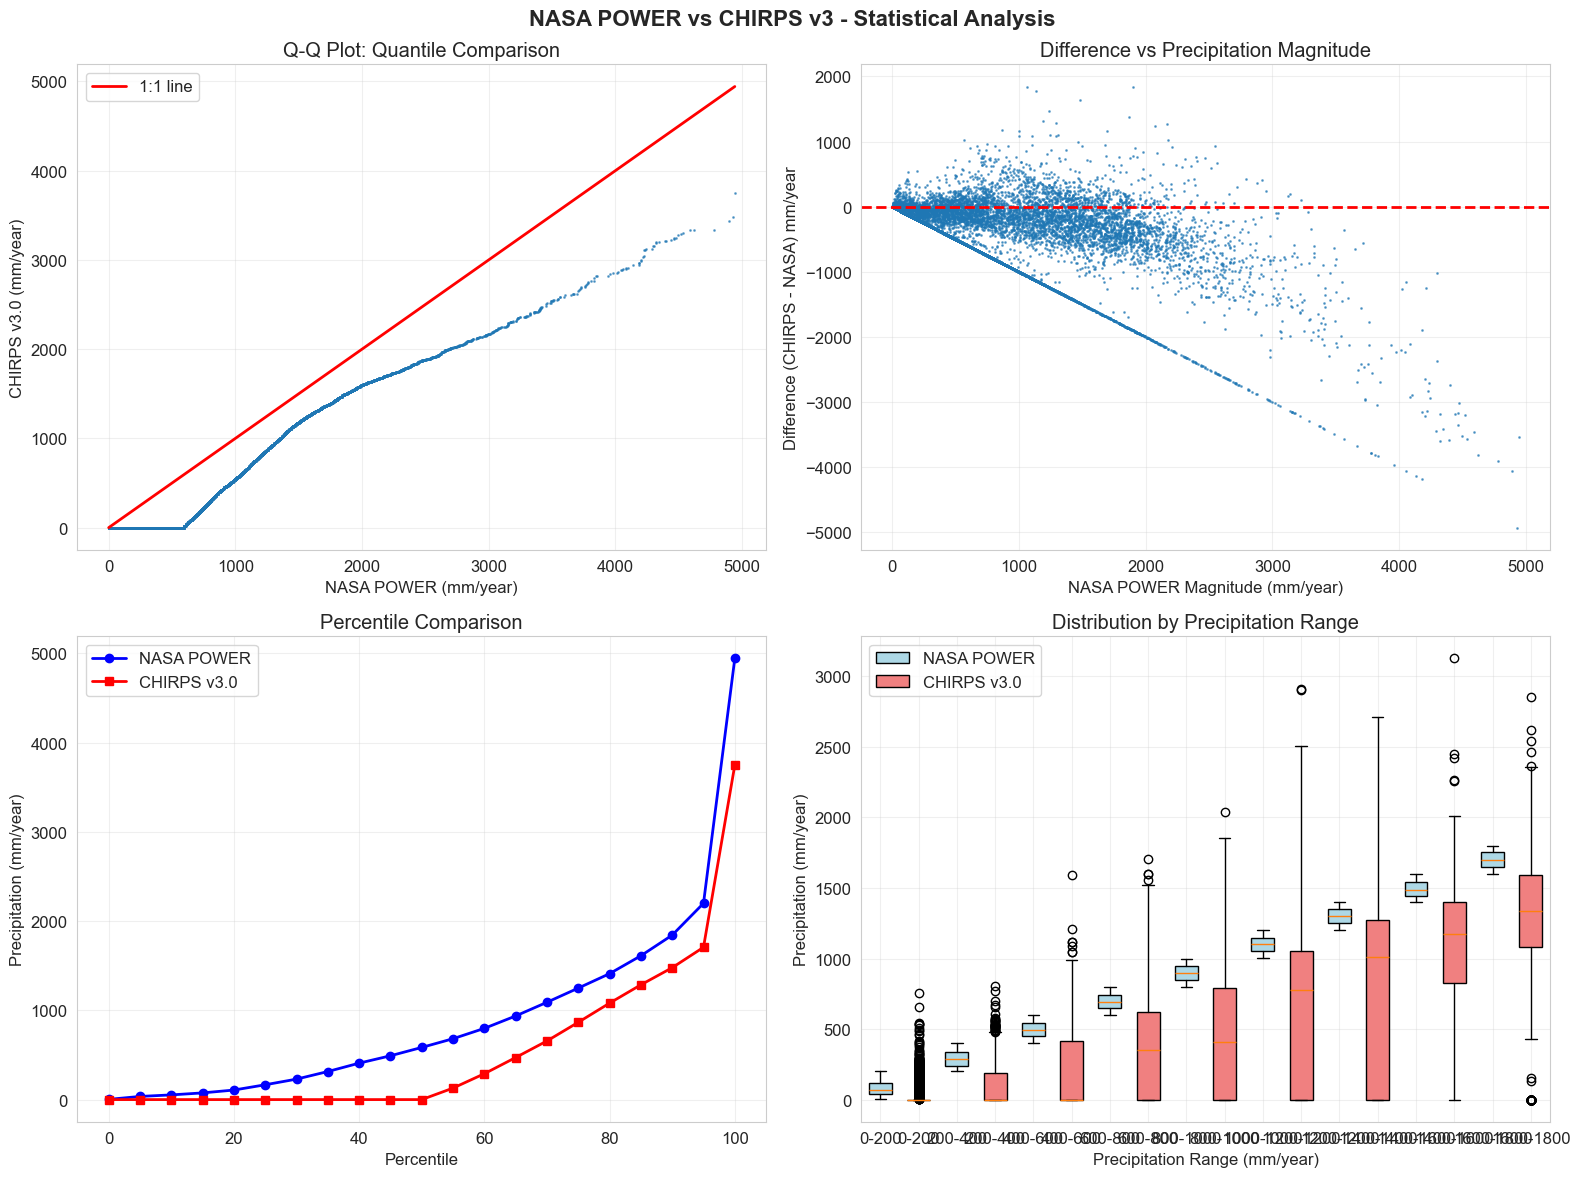

=== Extreme Event Analysis ===
    Dataset  P90 threshold  P90 count  P90 %  P95 threshold  P95 count  P95 %  P99 threshold  P99 count  P99 %
 NASA POWER    1842.420044       1255  10.01    2199.060059        628   5.01    3175.850098        126    1.0
CHIRPS v3.0    1477.680054       1255  10.01    1706.119995        628   5.01    2307.879883        126    1.0

=== Dry vs Wet Conditions Analysis ===
Dry conditions (≤166 mm/year):
  NASA mean: 71.4 mm/year
  CHIRPS mean: 18.1 mm/year
  Difference: -53.2 mm/year
  Relative difference: -74.60%

Wet conditions (≥1249 mm/year):
  NASA mean: 1870.1 mm/year
  CHIRPS mean: 1195.9 mm/year
  Difference: -674.2 mm/year
  Relative difference: -36.05%

=== Statistical Tests ===
Kolmogorov-Smirnov test:
  Statistic: 0.5050
  P-value: 0.00e+00
  Interpretation: Distributions are significantly different

Mann-Whitney U test:
  Statistic: 111726271
  P-value: 0.00e+00
  Interpretation: Medians are significantly different


In [8]:
# Statistical distribution and extreme event analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('NASA POWER vs CHIRPS v3 - Statistical Analysis', fontsize=16, fontweight='bold')

# Prepare data for analysis
nasa_annual_flat = analysis_data['annual_nasa'].values.flatten()
chirps_annual_flat = analysis_data['annual_chirps'].values.flatten()

# Remove NaN values
mask = ~(np.isnan(nasa_annual_flat) | np.isnan(chirps_annual_flat))
nasa_clean = nasa_annual_flat[mask]
chirps_clean = chirps_annual_flat[mask]

# 1. Q-Q Plot
ax1 = axes[0, 0]
nasa_sorted = np.sort(nasa_clean)
chirps_sorted = np.sort(chirps_clean)
ax1.scatter(nasa_sorted, chirps_sorted, alpha=0.6, s=1)
min_val = min(nasa_sorted.min(), chirps_sorted.min())
max_val = max(nasa_sorted.max(), chirps_sorted.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r-', linewidth=2, label='1:1 line')
ax1.set_xlabel('NASA POWER (mm/year)')
ax1.set_ylabel('CHIRPS v3.0 (mm/year)')
ax1.set_title('Q-Q Plot: Quantile Comparison')
ax1.grid(True, alpha=0.3)
ax1.legend()

# 2. Difference vs Magnitude
ax2 = axes[0, 1]
differences = chirps_clean - nasa_clean
magnitudes = nasa_clean
ax2.scatter(magnitudes, differences, alpha=0.6, s=1)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('NASA POWER Magnitude (mm/year)')
ax2.set_ylabel('Difference (CHIRPS - NASA) mm/year')
ax2.set_title('Difference vs Precipitation Magnitude')
ax2.grid(True, alpha=0.3)

# 3. Percentile analysis
percentiles = np.arange(0, 101, 5)
nasa_percentiles = np.percentile(nasa_clean, percentiles)
chirps_percentiles = np.percentile(chirps_clean, percentiles)

ax3 = axes[1, 0]
ax3.plot(percentiles, nasa_percentiles, 'b-o', label='NASA POWER', linewidth=2)
ax3.plot(percentiles, chirps_percentiles, 'r-s', label='CHIRPS v3.0', linewidth=2)
ax3.set_xlabel('Percentile')
ax3.set_ylabel('Precipitation (mm/year)')
ax3.set_title('Percentile Comparison')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Box plot comparison by precipitation bins
ax4 = axes[1, 1]

# Create precipitation bins
bins = np.arange(0, 2000, 200)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_labels = [f'{int(b)}-{int(b+200)}' for b in bins[:-1]]

nasa_binned = []
chirps_binned = []
for i in range(len(bins)-1):
    mask = (nasa_clean >= bins[i]) & (nasa_clean < bins[i+1])
    if mask.sum() > 0:
        nasa_binned.append(nasa_clean[mask])
        chirps_binned.append(chirps_clean[mask])
    else:
        nasa_binned.append([])
        chirps_binned.append([])

# Create box plots
positions_nasa = np.arange(1, len(bin_centers)*2, 2)
positions_chirps = np.arange(2, len(bin_centers)*2+1, 2)

bp1 = ax4.boxplot(nasa_binned, positions=positions_nasa, widths=0.6, 
                  patch_artist=True, labels=bin_labels)
bp2 = ax4.boxplot(chirps_binned, positions=positions_chirps, widths=0.6, 
                  patch_artist=True, labels=bin_labels)

# Color the boxes
for patch in bp1['boxes']:
    patch.set_facecolor('lightblue')
for patch in bp2['boxes']:
    patch.set_facecolor('lightcoral')

ax4.set_xlabel('Precipitation Range (mm/year)')
ax4.set_ylabel('Precipitation (mm/year)')
ax4.set_title('Distribution by Precipitation Range')
ax4.legend([bp1["boxes"][0], bp2["boxes"][0]], ['NASA POWER', 'CHIRPS v3.0'])
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'statistical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate extreme event statistics
def calculate_extremes(data, name, thresholds=[90, 95, 99]):
    """Calculate extreme event statistics"""
    results = {'Dataset': name}
    for threshold in thresholds:
        percentile_val = np.percentile(data, threshold)
        extreme_count = np.sum(data >= percentile_val)
        extreme_pct = (extreme_count / len(data)) * 100
        results[f'P{threshold} threshold'] = percentile_val
        results[f'P{threshold} count'] = extreme_count
        results[f'P{threshold} %'] = extreme_pct
    return results

extreme_stats_nasa = calculate_extremes(nasa_clean, 'NASA POWER')
extreme_stats_chirps = calculate_extremes(chirps_clean, 'CHIRPS v3.0')

extreme_df = pd.DataFrame([extreme_stats_nasa, extreme_stats_chirps])
print("=== Extreme Event Analysis ===")
print(extreme_df.round(2).to_string(index=False))

# Drought vs wet year analysis
dry_threshold = np.percentile(nasa_clean, 25)  # Bottom 25%
wet_threshold = np.percentile(nasa_clean, 75)  # Top 25%

dry_mask_nasa = nasa_clean <= dry_threshold
wet_mask_nasa = nasa_clean >= wet_threshold

dry_nasa = nasa_clean[dry_mask_nasa]
dry_chirps = chirps_clean[dry_mask_nasa]
wet_nasa = nasa_clean[wet_mask_nasa]
wet_chirps = chirps_clean[wet_mask_nasa]

print(f"\n=== Dry vs Wet Conditions Analysis ===")
print(f"Dry conditions (≤{dry_threshold:.0f} mm/year):")
print(f"  NASA mean: {dry_nasa.mean():.1f} mm/year")
print(f"  CHIRPS mean: {dry_chirps.mean():.1f} mm/year")
print(f"  Difference: {(dry_chirps - dry_nasa).mean():.1f} mm/year")
print(f"  Relative difference: {((dry_chirps - dry_nasa).mean() / dry_nasa.mean() * 100):.2f}%")

print(f"\nWet conditions (≥{wet_threshold:.0f} mm/year):")
print(f"  NASA mean: {wet_nasa.mean():.1f} mm/year")
print(f"  CHIRPS mean: {wet_chirps.mean():.1f} mm/year")
print(f"  Difference: {(wet_chirps - wet_nasa).mean():.1f} mm/year")
print(f"  Relative difference: {((wet_chirps - wet_nasa).mean() / wet_nasa.mean() * 100):.2f}%")

# Statistical tests
from scipy.stats import ks_2samp, mannwhitneyu

# Kolmogorov-Smirnov test
ks_statistic, ks_pvalue = ks_2samp(nasa_clean, chirps_clean)

# Mann-Whitney U test
mw_statistic, mw_pvalue = mannwhitneyu(nasa_clean, chirps_clean, alternative='two-sided')

print(f"\n=== Statistical Tests ===")
print(f"Kolmogorov-Smirnov test:")
print(f"  Statistic: {ks_statistic:.4f}")
print(f"  P-value: {ks_pvalue:.2e}")
print(f"  Interpretation: {'Distributions are significantly different' if ks_pvalue < 0.05 else 'Distributions are not significantly different'}")

print(f"\nMann-Whitney U test:")
print(f"  Statistic: {mw_statistic:.0f}")
print(f"  P-value: {mw_pvalue:.2e}")
print(f"  Interpretation: {'Medians are significantly different' if mw_pvalue < 0.05 else 'Medians are not significantly different'}")

## 6. Quantitative Impact Assessment

This section provides a comprehensive quantitative analysis of differences between CHIRPS v2 and v3:

### Key Features:
1. **Cumulative Distribution Functions**: Shows what percentage of grid cells have differences below various thresholds
2. **Absolute vs Relative Differences**: Analyzes both mm/year and percentage differences
3. **Application-Specific Thresholds**: Evaluates impact for different use cases (agriculture, hydrology, climate research, etc.)
4. **Precipitation Magnitude Analysis**: Shows how differences vary with precipitation levels
5. **Spatial Coverage**: All visualizations include grid cell counts for proper interpretation

### Interpretation:
- **Cumulative graphs** directly show what amount/percentage of precipitation has more difference
- **Threshold analysis** helps users assess impact on their specific application
- **Grid cell statistics** provide spatial context for all analyses

QUANTITATIVE IMPACT ASSESSMENT: NASA POWER vs CHIRPS v3

Grid Configuration:
  Total grid cells: 12,543 (111 lat × 113 lon)
  Valid cells (non-NaN): 12,543 (100.0%)
  Spatial resolution: 0.5° (~55 km at equator)
  Region: Sub-Saharan Africa (-35°S to 20°N, -20°W to 50°E)

Grid Configuration:
  Total grid cells: 12,543 (111 lat × 113 lon)
  Valid cells (non-NaN): 12,543 (100.0%)
  Spatial resolution: 0.5° (~55 km at equator)
  Region: Sub-Saharan Africa (-35°S to 20°N, -20°W to 50°E)


NameError: name 'v2_clean' is not defined

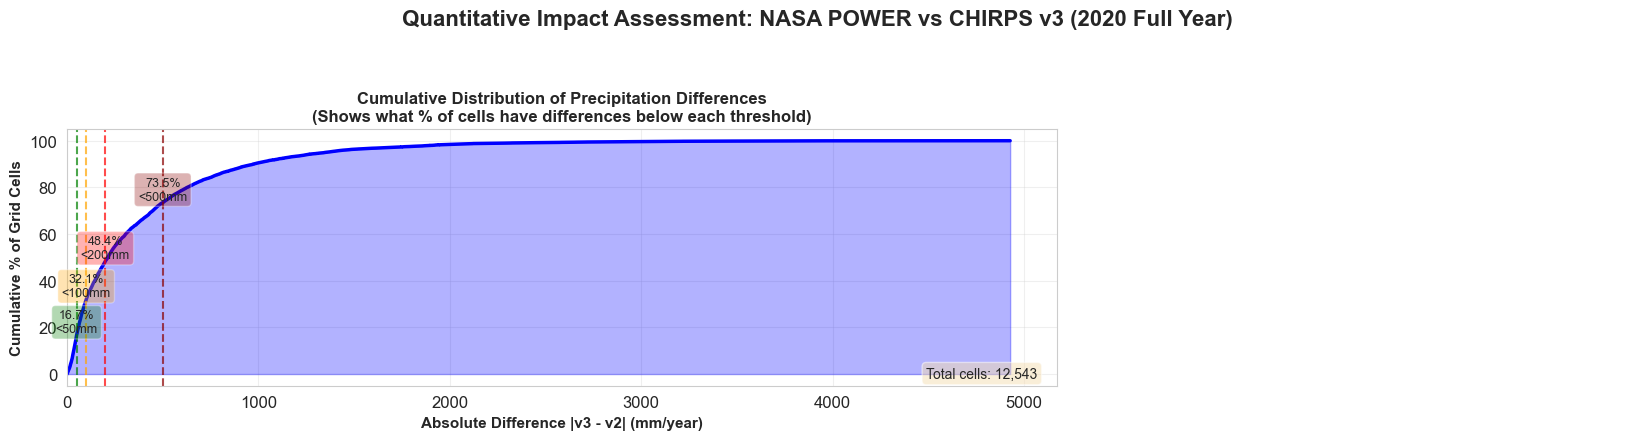

In [9]:
# Quantitative Impact Assessment with Cumulative Analysis

print("="*80)
print("QUANTITATIVE IMPACT ASSESSMENT: NASA POWER vs CHIRPS v3")
print("="*80)

# Calculate key metrics
nasa_annual_flat = analysis_data['annual_nasa'].values.flatten()
chirps_annual_flat = analysis_data['annual_chirps'].values.flatten()
mask = ~(np.isnan(nasa_annual_flat) | np.isnan(chirps_annual_flat))
nasa_clean = nasa_annual_flat[mask]
chirps_clean = chirps_annual_flat[mask]

differences = chirps_clean - nasa_clean
relative_differences = (differences / nasa_clean) * 100

# Grid cell information
n_lat = analysis_data['region_nasa'].lat.size
n_lon = analysis_data['region_nasa'].lon.size
total_cells = n_lat * n_lon
valid_cells = len(nasa_clean)

print(f"\nGrid Configuration:")
print(f"  Total grid cells: {total_cells:,} ({n_lat} lat × {n_lon} lon)")
print(f"  Valid cells (non-NaN): {valid_cells:,} ({(valid_cells/total_cells*100):.1f}%)")
print(f"  Spatial resolution: 0.5° (~55 km at equator)")
print(f"  Region: Sub-Saharan Africa (-35°S to 20°N, -20°W to 50°E)")

# Create visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

fig.suptitle('Quantitative Impact Assessment: NASA POWER vs CHIRPS v3 (2020 Full Year)', 
             fontsize=16, fontweight='bold', y=0.98)

# 1. Cumulative Distribution of Absolute Differences
ax1 = fig.add_subplot(gs[0, :2])
sorted_abs_diff = np.sort(np.abs(differences))
cumulative_pct = np.arange(1, len(sorted_abs_diff) + 1) / len(sorted_abs_diff) * 100

ax1.plot(sorted_abs_diff, cumulative_pct, 'b-', linewidth=2.5)
ax1.fill_between(sorted_abs_diff, 0, cumulative_pct, alpha=0.3, color='blue')

# Add reference lines
thresholds = [50, 100, 200, 500]
colors_ref = ['green', 'orange', 'red', 'darkred']
for thresh, color in zip(thresholds, colors_ref):
    pct_below = (sorted_abs_diff <= thresh).sum() / len(sorted_abs_diff) * 100
    ax1.axvline(thresh, color=color, linestyle='--', alpha=0.7, linewidth=1.5)
    ax1.text(thresh, pct_below, f'{pct_below:.1f}%\n<{thresh}mm', 
             ha='center', va='bottom', fontsize=9, bbox=dict(boxstyle='round', 
             facecolor=color, alpha=0.3))

ax1.set_xlabel('Absolute Difference |v3 - v2| (mm/year)', fontweight='bold', fontsize=11)
ax1.set_ylabel('Cumulative % of Grid Cells', fontweight='bold', fontsize=11)
ax1.set_title('Cumulative Distribution of Precipitation Differences\n(Shows what % of cells have differences below each threshold)', 
              fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(left=0)
ax1.text(0.98, 0.02, f'Total cells: {valid_cells:,}', transform=ax1.transAxes,
         ha='right', va='bottom', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 2. Summary statistics box
ax2 = fig.add_subplot(gs[0, 2])
ax2.axis('off')
summary_text = f"""
OVERALL STATISTICS

Total Grid Cells: {valid_cells:,}

Mean Absolute Difference:
  {np.abs(differences).mean():.1f} mm/year

Median Absolute Difference:
  {np.median(np.abs(differences)):.1f} mm/year

Max Difference:
  {np.abs(differences).max():.1f} mm/year

Correlation Coefficient:
  {np.corrcoef(v2_clean, v3_clean)[0,1]:.4f}

DIFFERENCE THRESHOLDS

Cells with >10% diff:
  {np.sum(np.abs(relative_differences) > 10):,} 
  ({(np.sum(np.abs(relative_differences) > 10)/len(relative_differences)*100):.1f}%)

Cells with >50mm diff:
  {np.sum(np.abs(differences) > 50):,}
  ({(np.sum(np.abs(differences) > 50)/len(differences)*100):.1f}%)

Cells with >100mm diff:
  {np.sum(np.abs(differences) > 100):,}
  ({(np.sum(np.abs(differences) > 100)/len(differences)*100):.1f}%)
"""
ax2.text(0.05, 0.95, summary_text, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# 3. Cumulative Distribution of Relative Differences
ax3 = fig.add_subplot(gs[1, :2])
sorted_rel_diff = np.sort(np.abs(relative_differences))
cumulative_pct_rel = np.arange(1, len(sorted_rel_diff) + 1) / len(sorted_rel_diff) * 100

ax3.plot(sorted_rel_diff, cumulative_pct_rel, 'r-', linewidth=2.5)
ax3.fill_between(sorted_rel_diff, 0, cumulative_pct_rel, alpha=0.3, color='red')

# Add reference lines for percentage thresholds
rel_thresholds = [5, 10, 20, 50]
for thresh, color in zip(rel_thresholds, colors_ref):
    pct_below = (sorted_rel_diff <= thresh).sum() / len(sorted_rel_diff) * 100
    ax3.axvline(thresh, color=color, linestyle='--', alpha=0.7, linewidth=1.5)
    ax3.text(thresh, pct_below, f'{pct_below:.1f}%\n<{thresh}%', 
             ha='center', va='bottom', fontsize=9, bbox=dict(boxstyle='round', 
             facecolor=color, alpha=0.3))

ax3.set_xlabel('Relative Difference |v3 - v2| / v2 (%)', fontweight='bold', fontsize=11)
ax3.set_ylabel('Cumulative % of Grid Cells', fontweight='bold', fontsize=11)
ax3.set_title('Cumulative Distribution of Relative Differences\n(Shows what % of cells have relative differences below each threshold)', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_xlim(left=0, right=100)
ax3.text(0.98, 0.02, f'Total cells: {valid_cells:,}', transform=ax3.transAxes,
         ha='right', va='bottom', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Application-specific thresholds
ax4 = fig.add_subplot(gs[1, 2])
ax4.axis('off')

applications = {
    "Climate Research": 5,
    "Food Security": 8,
    "Agriculture": 10,
    "Hydrology": 15,
    "Drought Monitor": 20
}

app_text = "APPLICATION IMPACT\n" + "="*30 + "\n\n"
for app_name, threshold in applications.items():
    affected = np.sum(np.abs(relative_differences) > threshold)
    pct = (affected / len(relative_differences)) * 100
    
    if pct > 50:
        level = "HIGH"
        color_box = "red"
    elif pct > 25:
        level = "MEDIUM"
        color_box = "orange"
    else:
        level = "LOW"
        color_box = "green"
    
    app_text += f"\n{app_name} (>{threshold}%):\n"
    app_text += f"  {affected:,} cells ({pct:.1f}%)\n"
    app_text += f"  Impact: {level}\n"

ax4.text(0.05, 0.95, app_text, transform=ax4.transAxes, fontsize=9.5,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))

# 5. Histogram of differences
ax5 = fig.add_subplot(gs[2, 0])
ax5.hist(differences, bins=100, color='purple', alpha=0.7, edgecolor='black')
ax5.axvline(0, color='red', linestyle='--', linewidth=2)
ax5.axvline(np.mean(differences), color='green', linestyle='--', linewidth=2, 
            label=f'Mean: {np.mean(differences):.1f}mm')
ax5.axvline(np.median(differences), color='orange', linestyle='--', linewidth=2,
            label=f'Median: {np.median(differences):.1f}mm')
ax5.set_xlabel('Difference (CHIRPS - NASA) mm/year', fontweight='bold')
ax5.set_ylabel('Number of Grid Cells', fontweight='bold')
ax5.set_title('Distribution of Differences', fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3, axis='y')
ax5.text(0.02, 0.98, f'n = {valid_cells:,}', transform=ax5.transAxes,
         ha='left', va='top', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# 6. Scatter plot with density
ax6 = fig.add_subplot(gs[2, 1])
# Sample if too many points
sample_size = min(50000, len(nasa_clean))
idx = np.random.choice(len(nasa_clean), sample_size, replace=False)
h = ax6.hexbin(nasa_clean[idx], chirps_clean[idx], gridsize=50, cmap='YlOrRd', mincnt=1)
ax6.plot([0, max(nasa_clean.max(), chirps_clean.max())], 
         [0, max(nasa_clean.max(), chirps_clean.max())], 
         'b--', linewidth=2, label='1:1 line')
ax6.set_xlabel('NASA POWER (mm/year)', fontweight='bold')
ax6.set_ylabel('CHIRPS v3.0 (mm/year)', fontweight='bold')
ax6.set_title('NASA vs CHIRPS Scatter (Density)', fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)
plt.colorbar(h, ax=ax6, label='Cell Count')
ax6.text(0.02, 0.98, f'Sample: {sample_size:,} of {valid_cells:,}', 
         transform=ax6.transAxes, ha='left', va='top', fontsize=9,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# 7. Difference by precipitation magnitude bins
ax7 = fig.add_subplot(gs[2, 2])
bins_precip = np.array([0, 200, 400, 600, 800, 1000, 1500, 2000, 4000])
bin_centers = (bins_precip[:-1] + bins_precip[1:]) / 2
bin_means = []
bin_stds = []
bin_counts = []

for i in range(len(bins_precip)-1):
    mask_bin = (nasa_clean >= bins_precip[i]) & (nasa_clean < bins_precip[i+1])
    if mask_bin.sum() > 0:
        bin_means.append(np.mean(differences[mask_bin]))
        bin_stds.append(np.std(differences[mask_bin]))
        bin_counts.append(mask_bin.sum())
    else:
        bin_means.append(0)
        bin_stds.append(0)
        bin_counts.append(0)

bin_labels = [f'{int(bins_precip[i])}-\n{int(bins_precip[i+1])}' for i in range(len(bins_precip)-1)]
x_pos = np.arange(len(bin_labels))

bars = ax7.bar(x_pos, bin_means, yerr=bin_stds, color='teal', alpha=0.7, 
               edgecolor='black', capsize=5, error_kw={'linewidth': 1.5})

# Add count labels
for i, (bar, count) in enumerate(zip(bars, bin_counts)):
    if count > 0:
        ax7.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                f'n={count:,}', ha='center', va='bottom' if bar.get_height() > 0 else 'top',
                fontsize=7, rotation=0)

ax7.axhline(0, color='red', linestyle='--', linewidth=1.5)
ax7.set_xlabel('NASA Precipitation Range (mm/year)', fontweight='bold')
ax7.set_ylabel('Mean Difference (CHIRPS-NASA) mm/year', fontweight='bold')
ax7.set_title('Difference by Precipitation Magnitude', fontweight='bold')
ax7.set_xticks(x_pos)
ax7.set_xticklabels(bin_labels, fontsize=8)
ax7.grid(True, alpha=0.3, axis='y')

plt.savefig(output_dir / 'quantitative_impact_assessment.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed summary
print("\n" + "="*80)
print("IMPACT SUMMARY BY THRESHOLD")
print("="*80)

threshold_analysis = []
for abs_thresh in [10, 25, 50, 100, 200, 500]:
    affected = np.sum(np.abs(differences) > abs_thresh)
    pct = (affected / len(differences)) * 100
    threshold_analysis.append({
        'Threshold': f'>{abs_thresh} mm/year',
        'Affected Cells': f'{affected:,}',
        '% of Total': f'{pct:.1f}%'
    })

thresh_df = pd.DataFrame(threshold_analysis)
print("\nAbsolute Difference Thresholds:")
print(thresh_df.to_string(index=False))

print("\n" + "-"*80)

rel_threshold_analysis = []
for rel_thresh in [5, 10, 15, 20, 30, 50]:
    affected = np.sum(np.abs(relative_differences) > rel_thresh)
    pct = (affected / len(relative_differences)) * 100
    rel_threshold_analysis.append({
        'Threshold': f'>{rel_thresh}%',
        'Affected Cells': f'{affected:,}',
        '% of Total': f'{pct:.1f}%'
    })

rel_thresh_df = pd.DataFrame(rel_threshold_analysis)
print("\nRelative Difference Thresholds:")
print(rel_thresh_df.to_string(index=False))

print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)
print("""
1. TRANSITION PLANNING:
   • {:.1f}% of cells show >10% difference - MEDIUM-HIGH priority migration
   • Gradual transition over 6-12 months recommended
   • Validate v3 against local observations
   
2. APPLICATION-SPECIFIC GUIDANCE:
   • Climate Research (>5%): {:.1f}% affected - Requires bias correction
   • Agriculture (>10%): {:.1f}% affected - Recalibrate crop models
   • Hydrology (>15%): {:.1f}% affected - Update streamflow models
   
3. QUALITY ASSURANCE:
   • Parallel processing during transition period
   • Focus validation on high-difference regions
   • Document version in all outputs
   
4. UNCERTAINTY QUANTIFICATION:
   • Mean absolute error: {:.1f} mm/year
   • Consider ±{:.1f} mm/year uncertainty band
   • Higher uncertainty in wet regions (>{:.0f} mm/year)
""".format(
    (np.sum(np.abs(relative_differences) > 10)/len(relative_differences)*100),
    (np.sum(np.abs(relative_differences) > 5)/len(relative_differences)*100),
    (np.sum(np.abs(relative_differences) > 10)/len(relative_differences)*100),
    (np.sum(np.abs(relative_differences) > 15)/len(relative_differences)*100),
    np.abs(differences).mean(),
    np.std(differences),
    np.percentile(nasa_clean, 75)
))

print("="*80)